# Imports

In [20]:
#workhorses
import numpy as np
import pandas as pd

import itertools

#for custom colormaps
from matplotlib.colors import LinearSegmentedColormap

#for proxy artists for legends
import matplotlib.lines as mlines

import seaborn as sns

# Plotting modules
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
#plotting things

#%matplotlib qt5 -- I don't know what this is
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from cycler import cycler


#All of Anandh's customized seaborn/matplotlib settings

sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')

    #If you want to use a different font
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(9,8))

## get data

In [3]:
directory = 'Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20190621 a=b deg 1/'

filename = '20190621 a=b degm 1.xlsx'

In [4]:
dd = pd.read_excel(directory + filename, sheet_name=None)

In [5]:
dd.keys()

odict_keys(['OD700', 'CFP', 'YFP', 'OD700_tidy', 'CFP_tidy', 'YFP_tidy', 'all_tidy', 'IDs', 'Exp'])

In [6]:
sheets_to_plot = [x for x in dd.keys() if 'tidy' in x]

In [7]:
sheets_to_plot

['OD700_tidy', 'CFP_tidy', 'YFP_tidy', 'all_tidy']

## make relevant indices

In [8]:
#which data are we plotting
data = sheets_to_plot[3]

In [37]:
#get the control ones
# ctrl = dd[data]['a'] == 'ctrl'

#get the media blank ones
# med = dd[data]['a'] == 'lb'

#get the ones without a and b cells
no_a = dd[data]['a'] == 'x'
no_b = dd[data]['b'] == 'x'
mix = ~no_a & ~no_b

#get only ON and OFF
sal_0 = dd[data]['sal'] == 0
iptg_0 = dd[data]['iptg'] == 0
ara_0 = dd[data]['ara'] == 0

sal_hi = ~sal_0
iptg_hi = ~iptg_0
ara_hi = ~ara_0

#get the ones in the first growth cycle
# first = dd[data]['dil'] == 0

#now all the mixes should be accessible by asking for 
#NOT the no a and b indices and NOT the ctrl and med indices

inds = mix & ara_0

# *Time course data plots*

In [92]:
i = no_b & ara_0

df = dd[data].loc[i]

In [93]:
inducers = ['iptg', 'sal', 'ara']
g = [np.unique(df[ind]) for ind in inducers]

conds = list(itertools.product(g[0], g[1], g[2]))

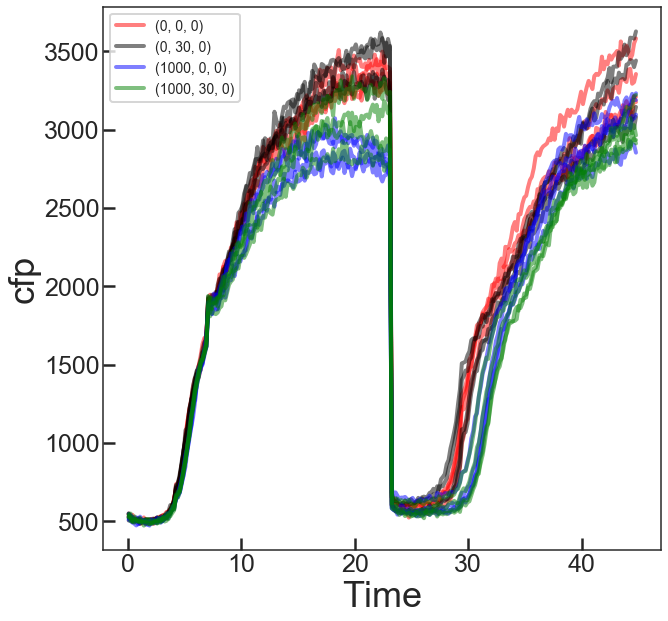

In [95]:
fig = plt.figure(figsize=(10,10))


for cond in conds:

    ii = (df['iptg'] == cond[0]) & (df['sal'] == cond[1]) & (df['ara'] == cond[2])
    
    d = df.loc[ii]
    
    sns.lineplot(x="Time", y="cfp", units='well', lw=4, alpha=0.5, estimator=None, data=d)
    
lines = list(fig.axes[0].get_lines())
ls = lines[::4]
    
plt.legend(handles = ls, labels = conds)

# Generate a facetgrid for all the wells showing just one measurement over time

## access and format the data

In [71]:
df = dd[data].loc[inds]

#having an issue where fluor values are being read as "object" rather than numbers
# df.loc[:,'value'] = df.loc[:, 'value'].astype(float)

In [72]:
df.columns

Index(['Time', 'Temp C', 'well', 'od700', 'a', 'b', 'iptg', 'sal', 'ara',
       'cfp', 'yfp', 'cfp_norm', 'yfp_norm', 'dil'],
      dtype='object')

In [73]:
all_sal = np.unique(df['sal'])
all_iptg = np.unique(df['iptg'])
all_ara = np.unique(df['ara'])

In [74]:
###get relevant info for color mapping

#what are the unique inducer conditions you want to make diff colors
ind_concs = np.unique(df['ara'])
ind_labels = ['OFF', 'ON']

#create a list of values from x-1 of same length as unique inducer concs
#this gets fed to the cmap to get rgb colors
mapping_list = np.linspace(0.37,1,len(ind_concs))

###get some colors that cover all the inducer conditions

#select your color map
names = {'b' : 'Blues', 'y' : 'YlOrBr', 'black' : 'binary'}

cmaps = {k:mpl.cm.get_cmap(v) for (k,v) in names.items()}


#create a list of rgb tuples
clist = {k : [cmap(x) for x in mapping_list] for (k,cmap) in cmaps.items()}


#create the palette dictionary for the facegrid function
pal = {k : {conc:color for conc,color in zip(ind_concs, rgb_tuples)} for (k, rgb_tuples) in clist.items()}

In [75]:
def custom_pal_lineplot (x, y, **kwargs):
    
    #set the plotting to go to the current axis
    #this is a requirement for using function in mapping to facetgrid
    ax = plt.gca()
    
    #remove the data from the kwargs (where facetgrid puts the data)
    #and store it in this variable
    data = kwargs.pop("data")
    
    #get the passed palette out to get colors for color.
    #facetgrid passes a label in the kwargs too which is whatever value of the "hue"
    #param it is plotting at the moment
    pal = kwargs.pop('palette')

    #get the label out
    label = kwargs.pop('label')
    
    
    sns.lineplot(x=x, y=y, data=data, ci=kwargs['ci'], color=pal[label], dashes=True, linewidth=kwargs['linewidth'], ax=ax)

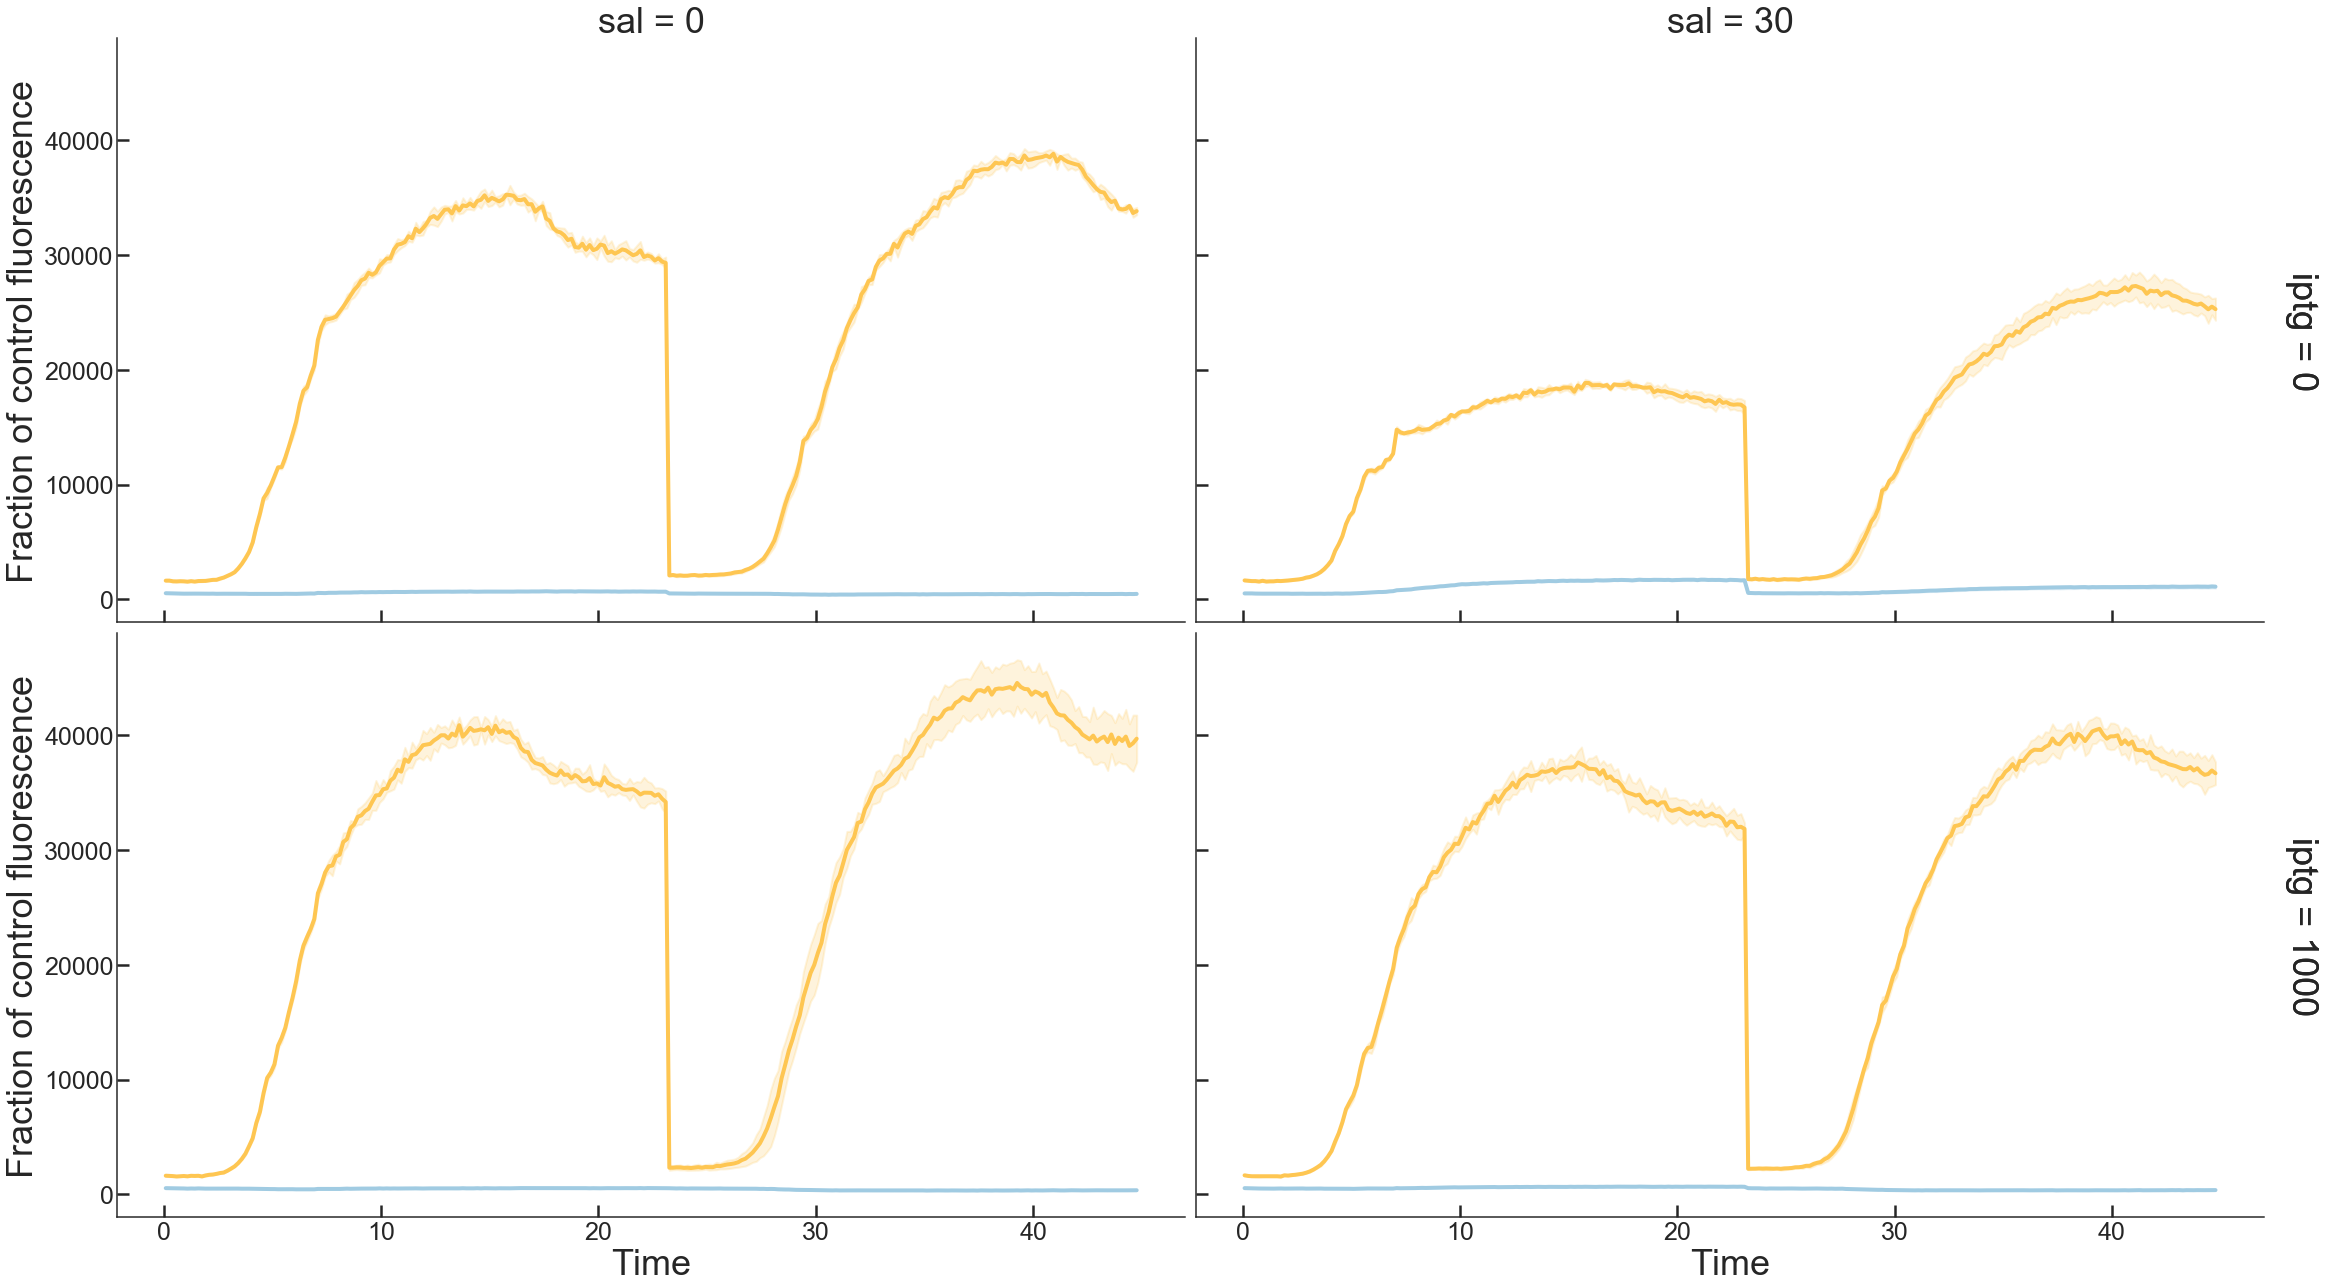

In [76]:
g = sns.FacetGrid(df, col='sal', row='iptg', hue='ara',
                  height=9, aspect=1.8, margin_titles=True, legend_out=False)

#set kws for the first set of lines
kws = {'ci': 'sd', 'linewidth' : 4, 'palette' : pal['y']}
g.map_dataframe(custom_pal_lineplot, "Time", "yfp", **kws)

# set new kws for the second set of lines
kws = {'ci': 'sd', 'linewidth' : 4, 'palette' : pal['b']}
g.map_dataframe(custom_pal_lineplot, "Time", "cfp", **kws)


#create a custom legend
# proxy_lines = [mlines.Line2D([], [], color=pal['black'][i], linewidth=4) for i in ind_concs]

# g.fig.legend(handles=proxy_lines, labels=ind_labels + ind_labels, title='IPTG uM, Sal uM',
#              fontsize='small', bbox_to_anchor=(0.42, 0.95))


g.set_axis_labels('Time', "Fraction of control fluorescence")

In [249]:
# g.savefig(directory + 'all_ab_combos_onoff_od.pdf')

# *CFP/YFP space*

### access just the data you'll use here

In [120]:
##get the data
d=dd[data]

##get the indices

#get the control ones
ctrl = dd[data]['a'] == 'ctrl'

#get the media blank ones
med = dd[data]['a'] == 'lb'

#get the ones without a and b cells
no_a = dd[data]['a'] == 'x'
no_b = dd[data]['b'] == 'x'

#get the ones in the first growth cycle
first = dd[data]['dil'] == 0

#now all the mixes should be accessible by asking for 
#NOT the no a and b indices and NOT the ctrl and med indices

mix = ~no_a & ~no_b & ~ctrl & ~med

In [168]:
###get relevant info for color mapping

#what are the unique inducer conditions you want to make diff colors
ind_concs = np.unique(d['iptg'])
ind_labels = all_ind_pairs

#create a list of values from x-1 of same length as unique inducer concs
#this gets fed to the cmap to get rgb colors
mapping_list = np.linspace(0.4,1,len(ind_concs))

###get some colors that cover all the inducer conditions

#select your color map
cmap = mpl.cm.get_cmap('BuGn')

#create a list of rgb tuples
clist = [cmap(x) for x in mapping_list]

#create the palette dictionary for the facegrit function
pal = {conc : color for conc,color in zip(ind_concs, clist)}

## make the plot

In [169]:
def bin_scatter_sd (x, y, **kwargs):
    """
    from more or less continuous data in 2d fluorescence space, plot a binned scatterplot with sd confidence intervals
    """
    #set the plotting to go to the current axis
    #this is a requirement for using function in mapping to facetgrid
    ax = plt.gca()
    
    #remove the data from the kwargs (where facetgrid puts the data)
    #and store it in this variable
    data = kwargs.pop("data")
    
    #also pop out the color entry from kwargs (it gets this from palette you set in facetgrid)
    color = kwargs.pop("color")
    
    #also get the legend labels
    label = kwargs.pop("label")
    
    #do a regplot without the fit (so a scatter)
    sns.regplot(x=x, y=y, data=data, fit_reg=False,
                #bin the data on the x axis to allow computation of confidence intervals on the 4 replicate traces
                x_bins=125, x_ci='sd',
                #adjust colors, size and alpha of scatter points, other aesthetics
                color=color, scatter_kws={"s": 35, 'alpha' : kwargs['alpha']},
                #matplotlib object stuff
                ax=ax, label=label)
    
    #adjust the alpha of the confidence interval lines, since those are the only line objects on the plot
    plt.setp(ax.get_lines(), alpha=kwargs['alpha']);

In [170]:
df = d.loc[mix]

In [171]:
g = sns.FacetGrid(df, col="a", row ="b", hue='iptg', palette=pal,
                  height=8, aspect=1.3, margin_titles=True, legend_out=True)


g.map_dataframe(bin_scatter_sd, "cfp_recntr", "yfp_recntr", **{'alpha' : 0.6})


######################### adding reference curves

#plot the a only data on the axes
for axis in g.fig.get_axes():
    #set the current axis to one of the figure axes
    plt.sca(axis)
    
    #create kwargs to match bin_scatter_sd syntax
    ref_data_a = d.loc[no_b]
    color = mpl.colors.to_rgba('blue')
    kwargs = {'color' : color, 'data' : ref_data_a, 'label' : 'A only', 'alpha' : 0.15}
    
    #plot
    bin_scatter_sd("cfp_recntr", "yfp_recntr", **kwargs)
    
    
for axis, b_type in zip(g.fig.get_axes(), np.unique(d.loc[no_a, 'b'])):
    #set the current axis to one of the figure axes
    plt.sca(axis)
    
    #create kwargs to match bin_scatter_sd syntax
    i = no_a & (d['b'] == b_type)
    ref_data_a = d.loc[i]
    color = mpl.colors.to_rgba('goldenrod')
    kwargs = {'color' : color, 'data' : ref_data_a, 'label' : 'B only', 'alpha' : 0.15}
    
    #plot
    bin_scatter_sd("cfp_recntr", "yfp_recntr", **kwargs)
    

########## aesthetics
g.set_axis_labels("CFP", "YFP")
    
plt.close()




C:\Users\geeze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [27]:
#get one of the axes on which the data is drawn
ax = g.fig.get_axes()[0]

#get the handles (objects assigned labels) and the labels of those handles
handles, labels = ax.get_legend_handles_labels()

#replace the labels with the ones you made earlier
(g.fig.legend(handles, all_ind_pairs + labels[-2:], fontsize='xx-small', bbox_to_anchor=(0.92, 0.92))
 .set_title("IPTG uM, Sal uM", prop = {'size':'x-small'}))

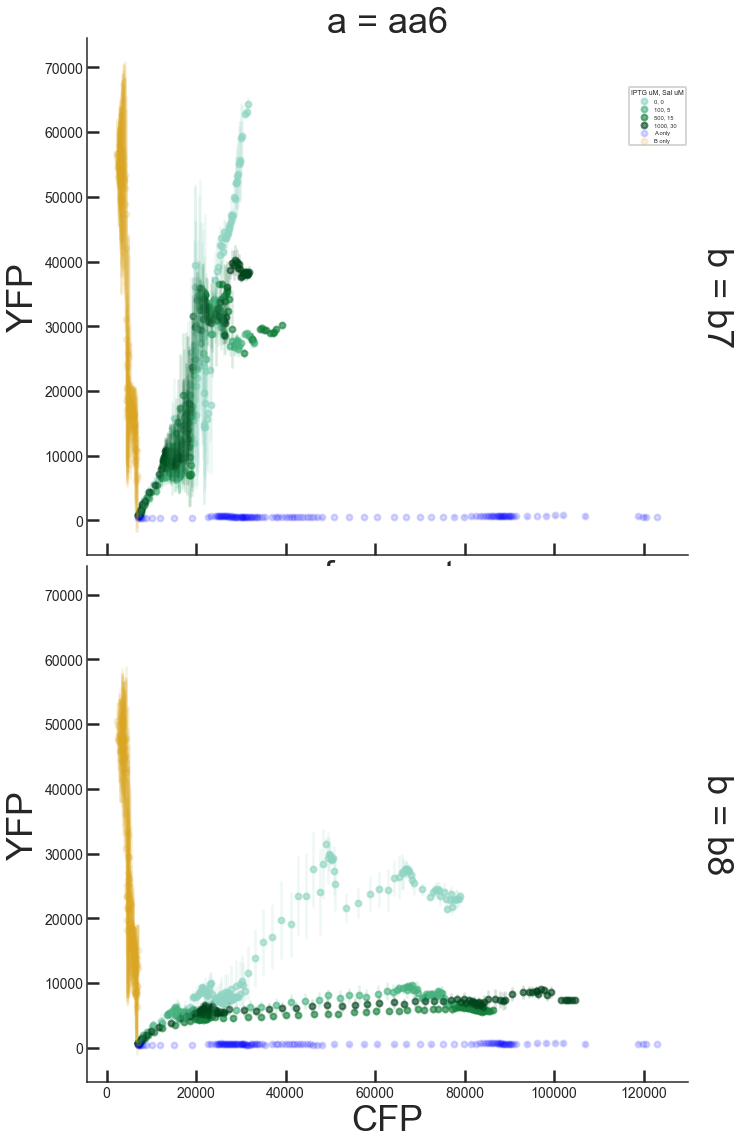

In [28]:
g.fig

In [29]:
g.savefig(directory + 'both_fluor_scatter_full_recntr_refs.pdf')